[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Пользователь\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Пользователь\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


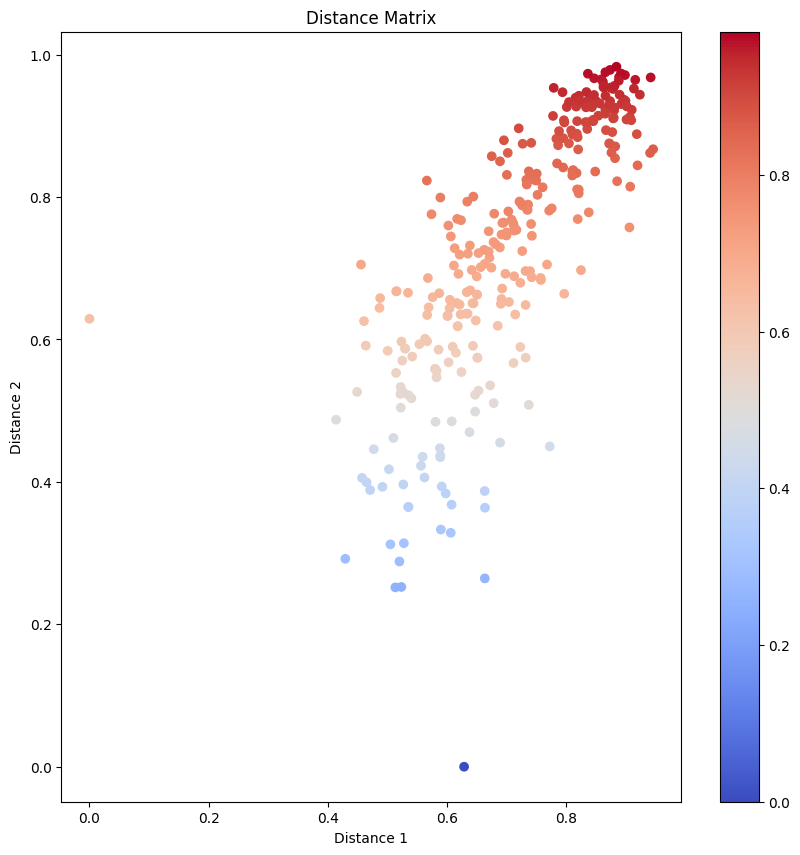

Average silhouette score: 0.35128466053002794


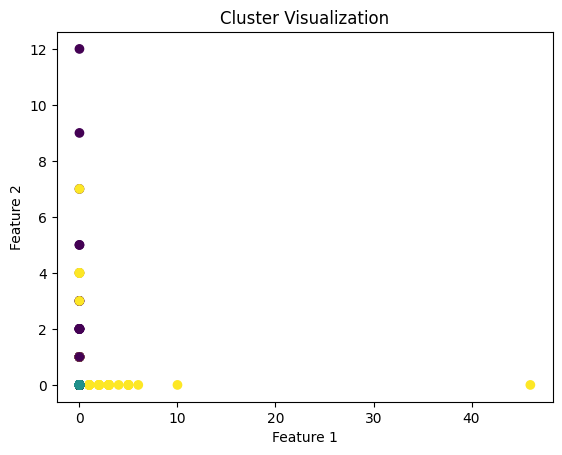

In [6]:
import os
import zipfile
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pymorphy3
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import pdist, squareform
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

# Загрузка NLTK ресурсов
nltk.download('punkt')
nltk.download('stopwords')

# Распаковка архива с текстовыми документами
with zipfile.ZipFile('2021_SPORT.zip', 'r') as zip_ref:
    zip_ref.extractall('2021_SPORT')

# Предварительная обработка текстовых документов
corpus = []
morph = pymorphy3.MorphAnalyzer()
stop_words = set(stopwords.words('russian'))

for root, dirs, files in os.walk("2021_SPORT"):
    for file in files:
        with open(os.path.join(root, file), 'r', encoding='utf-8') as f:
            text = f.read()
            tokens = word_tokenize(text)
            tokens = [morph.parse(token)[0].normal_form for token in tokens if token.isalnum() and not token.isdigit()]
            tokens = [token for token in tokens if token not in stop_words]
            text = ' '.join(tokens)
            corpus.append(text)

# Векторизация текстов
vectorizer = CountVectorizer(max_features=150)
X = vectorizer.fit_transform(corpus).toarray()

# Построение матрицы расстояний и визуализация
distance_matrix = squareform(pdist(X, metric='cosine'))

# Добавление цветовой полосы для графика матрицы расстояний
plt.figure(figsize=(10, 10))
plt.scatter(distance_matrix[:,0], distance_matrix[:,1], c=distance_matrix[:,1], cmap='coolwarm', marker='o')
plt.colorbar()
plt.title('Distance Matrix')
plt.xlabel('Distance 1')
plt.ylabel('Distance 2')
plt.show()

# Кластерный анализ
similarity_matrix = np.exp(-distance_matrix ** 2 / (2. * 4.0 ** 2))  # Преобразуем матрицу расстояний в матрицу сходства
spectral = SpectralClustering(affinity='precomputed', random_state=0, n_clusters=3)
clusters = spectral.fit_predict(similarity_matrix)

# Оценка качества кластеризации
silhouette_avg = silhouette_score(similarity_matrix, clusters)
print("Average silhouette score:", silhouette_avg)

# Визуализация кластеров
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis')
plt.title('Cluster Visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()